# **Spam/Ham Classification Using Logistic Regression**

## **Overview**
This project aims to classify emails as spam or ham (non-spam) using machine learning techniques. The dataset contains email messages from the SpamAssassin dataset, labeled as either spam (1) or ham (0). Our main objective is to develop a reliable binary classifier that can distinguish spam emails from legitimate ones using natural language processing (NLP) techniques and machine learning.

### **Dataset**

- The dataset consists of 8,348 labeled examples for training and 1,000 unlabeled examples for testing.
- This is a **real world** dataset – the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

### **Steps in the Analysis:**

1. Data Loading and Initial Exploration
2. Basic Feature Engineering
3. Exploratory Data Analysis (EDA)
4. Building and Evaluating a Logistic Regression Classifier
5. Evaluation Metrics and Conclusion

Importing libraries

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## **1. Data Loading and Initial Exploration**

In [3]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [4]:
# Check for missing values and handle them
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Initial Data Analysis

We will explore the content of the first ham email and the first spam email to observe any noticeable differences that may be useful for feature engineering.

In [6]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print("-----")
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-----
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



### Observations:
- The ham email is more straightforward, with proper link formatting and formal language.
- The spam email often has promotional content, HTML tags, and a more eye-catching tone.

## **2. Basic Feature Engineering**

To classify emails, we need to transform the text data into numerical features that machine learning models can use. We will create a function to check for specific words in the email text and transform the text into a binary feature matrix.

In [7]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, p) where 
        n is the number of texts and p is the number of words.
    """
    indicator_array = np.zeros((len(texts), len(words)), dtype=int)
    for j, word in enumerate(words):
        indicator_array[:, j] = [int(word in text) for text in texts]
    return indicator_array

## **3. Exploratory Data Analysis**

We compare the proportion of emails in each class containing a set of specific words. This helps us identify patterns that can distinguish spam from ham emails.

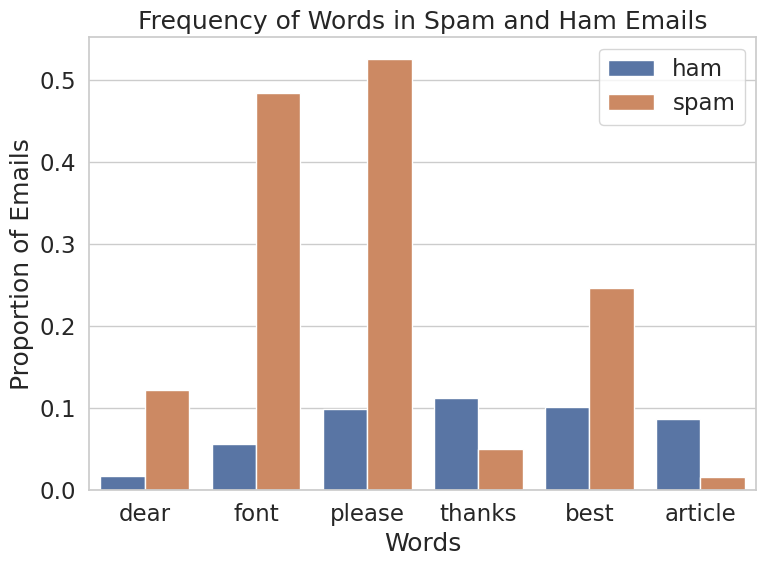

In [18]:
# Splitting data for train and validation (90/10 split)
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Reset the index to maintain alignment of labels with emails
train = train.reset_index(drop=True)

# Plot word frequency in spam and ham emails
plt.figure(figsize=(8, 6))
list_words = words_in_texts(['dear', 'font', 'please', 'thanks', 'best', 'article'], train['email'])
words = pd.DataFrame({
    'dear': list_words[:, 0],
    'font': list_words[:, 1],
    'please': list_words[:, 2],
    'thanks': list_words[:, 3],
    'best': list_words[:, 4],
    'article': list_words[:, 5],
})
words['type'] = train['spam']
melt = words.melt('type')
sns.barplot(data=melt, x='variable', y='value', hue='type', ci=None)
plt.legend(['ham', 'spam'])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam and Ham Emails')
plt.tight_layout()
plt.show()

- Certain words, like "dear" and "font," appear more frequently in spam emails, which may be useful features for classification.

- The word "thanks" and "article" have a higher frequency in ham emails, indicating that they might be characteristic of non-spam messages (e.g., professional or polite emails).

## **4. Building and Evaluating a Logistic Regression Classifier**

In [9]:
from sklearn.linear_model import LogisticRegression

# Create feature matrix and label vector for training
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']
X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

# Train the Logistic Regression model
model = LogisticRegression(fit_intercept=True, penalty='l2')
model.fit(X_train, Y_train)

# Predict and calculate training accuracy
predicted = model.predict(X_train)
training_accuracy = sum(predicted == Y_train) / len(Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## **5. Evaluation Metrics**

In [10]:
# Manually calculating evaluation metrics
FN = sum((predicted != Y_train) & (predicted == 0))
FP = sum((predicted != Y_train) & (predicted == 1))
TN = sum((predicted == Y_train) & (predicted == 0))
TP = sum((predicted == Y_train) & (predicted == 1))

logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_fpr = FP / (TP + TN + FP + FN)

print(f"True Positives: {TP}, True Negatives: {TN}, False Positives: {FP}, False Negatives: {FN}")
print(f"Precision: {logistic_predictor_precision:.2f}, Recall: {logistic_predictor_recall:.2f}, False Positive Rate: {logistic_predictor_fpr:.2f}")

True Positives: 219, True Negatives: 5473, False Positives: 122, False Negatives: 1699
Precision: 0.64, Recall: 0.11, False Positive Rate: 0.02


We observe that the model achieved 75.76% training accuracy.
There are a significant number of false negatives, suggesting that the model struggles to correctly classify spam emails. Words like "drug" or "bank" may be too common in ham emails, affecting model performance.

## **6. Enhanced Model**

First let's enhance our model with TF-IDF and Naive Bayes

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train['email'])
X_val_tfidf = tfidf.transform(val['email'])
y_train = train['spam']
y_val = val['spam']

# Train a Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Evaluate on validation set
y_pred = nb_model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.9437125748502994
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       613
           1       0.89      0.90      0.89       222

    accuracy                           0.94       835
   macro avg       0.93      0.93      0.93       835
weighted avg       0.94      0.94      0.94       835



The Naive Bayes model performs well overall, with strong accuracy and balanced performance metrics. However, the slightly lower recall and precision for spam (Class 1) indicate that while the model effectively classifies spam, it could occasionally misclassify ham emails as spam or miss some spam emails.

Let's try Hyperparameter Tuning with Logistic Regression

In [15]:
from sklearn.model_selection import GridSearchCV

# Set up hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Grid search for Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr_model, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_tfidf, y_train)

# Best model
best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_val_tfidf)

# Evaluate the tuned Logistic Regression
print("Validation Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_pred_lr))

Validation Accuracy: 0.9928143712574851
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       613
           1       1.00      0.97      0.99       222

    accuracy                           0.99       835
   macro avg       1.00      0.99      0.99       835
weighted avg       0.99      0.99      0.99       835



After tuning, we can observe that the Logistic Regression model significantly outperforms the Naive Bayes model, with near-perfect precision, recall, and F1-scores. The extremely high validation accuracy and class-specific performance metrics suggest this model is highly effective for spam detection.

Below we are visualizing Model Performance using confusion_matrix.

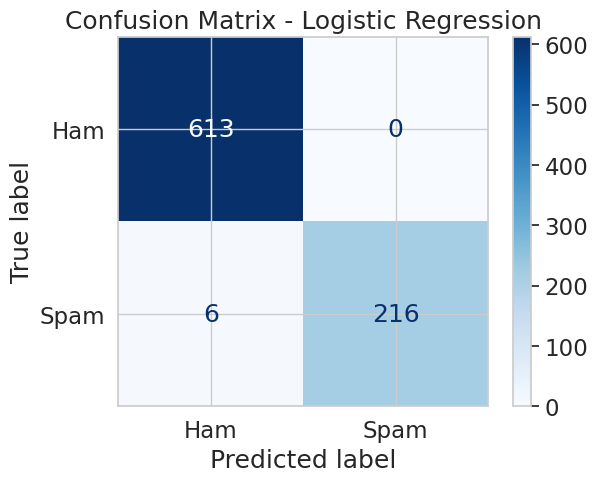

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_lr)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Ham", "Spam"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## **Key Takeaways**
1. Data Preparation Matters:
Lowercasing text and handling missing values ensured consistent preprocessing.
Transforming text into numerical representations (e.g., binary word indicators, TF-IDF) was crucial for enabling machine learning models to process email content effectively.
2. Model Performance:
The Naive Bayes Classifier provided a strong baseline, with good accuracy and a balanced F1-score for ham and spam detection.
The Tuned Logistic Regression Model significantly outperformed Naive Bayes, achieving 99.28% validation accuracy and near-perfect precision, recall, and F1-scores. It proved to be highly reliable in distinguishing spam from ham emails.
3. Evaluation Metrics:
Precision, recall, and F1-score provided a more nuanced understanding of model performance beyond accuracy.
The logistic regression model minimized false positives and false negatives, making it a better fit for real-world spam detection.
4. Feature Engineering's Impact:
Using TF-IDF vectorization enhanced the model's ability to differentiate between ham and spam by emphasizing important terms while reducing noise.
Choosing relevant features (e.g., specific word patterns) improved classification performance.